# Problem 1
## 1. Introduction
In this task, we will be working with a month of pitch data. On the basis of this data, the goal of this task is to develop a framework which is capable of classifying whether a given pitch is a strike or ball and further predicting its **Called Strike Probability**. The framework is basically composed of below parts: feature preprocessing, model building, hyperparameter tuning, model evaluation, feature importance, feature selection, probability calibration, visualization, and further analysis of pitchers.

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.lines import Line2D
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from scipy.ndimage.filters import gaussian_filter

## 2. Feature Preprocessing
Again, our main goal is to classify whether a given pitch is a strike or ball and further predict its predict called strike probability. Therefore, in the first stage, we only select a subset of the given data whose pitch results are **Strike Called** or **Ball Called**. After that, we check the data type of each feature and then encode several features, such as `PITCH_RESULT` and `PITCH_RESULT`, whose data types are object. Finally, we convert the data types of several features, such as `UMPIRE_ID`, `STRIKES`, and `PITCH_TYPE`, into category.

In [54]:
# load the data and select a subet of the given data
raw_data = pd.read_csv('data/pitch_data_one_month.csv', index_col=0)
data = raw_data[(raw_data['PITCH_RESULT'] == 'StrikeCalled') |
                (raw_data['PITCH_RESULT'] == 'BallCalled')].reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65925 entries, 0 to 65924
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   GAME_ID                    65925 non-null  int64  
 1   PA_IN_GAME                 65925 non-null  int64  
 2   PITCH_IN_PA                65925 non-null  int64  
 3   CATCHER_ID                 65925 non-null  int64  
 4   PITCHER_ID                 65925 non-null  int64  
 5   BATTER_ID                  65925 non-null  int64  
 6   UMPIRE_ID                  65925 non-null  int64  
 7   BALLPARK_ID                65925 non-null  int64  
 8   BALLS                      65925 non-null  int64  
 9   STRIKES                    65925 non-null  int64  
 10  OUTS                       65925 non-null  int64  
 11  INNING                     65925 non-null  int64  
 12  INNING_HALF                65925 non-null  object 
 13  AWAY_TEAM_SCORE            65925 non-null  int

In [57]:
# feature encoding and data type conversion
for feature in ['PITCH_RESULT', 'BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_TYPE', 'INNING_HALF', 'EVENT_RESULT']:
    le = preprocessing.LabelEncoder()
    le.fit(data[feature])
    encoded_label = le.transform(data[feature])
    data[feature] = pd.DataFrame(encoded_label)

categorical_features = ['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID', 'BALLS', 'STRIKES', 'OUTS', 'INNING',
                        'BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_TYPE', 'INNING_HALF', 'PITCH_RESULT', 'EVENT_RESULT']
for feature in categorical_features:
    data[feature] = data[feature].astype('category')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65925 entries, 0 to 65924
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   GAME_ID                    65925 non-null  int64   
 1   PA_IN_GAME                 65925 non-null  int64   
 2   PITCH_IN_PA                65925 non-null  int64   
 3   CATCHER_ID                 65925 non-null  category
 4   PITCHER_ID                 65925 non-null  category
 5   BATTER_ID                  65925 non-null  category
 6   UMPIRE_ID                  65925 non-null  category
 7   BALLPARK_ID                65925 non-null  int64   
 8   BALLS                      65925 non-null  category
 9   STRIKES                    65925 non-null  category
 10  OUTS                       65925 non-null  category
 11  INNING                     65925 non-null  category
 12  INNING_HALF                65925 non-null  category
 13  AWAY_TEAM_SCORE            6592

## 3. Model Building and Hyperparameter Tuning
After feature preprocessing, we define two important functions to assist us in building a classification model and tuning its hyperparameters. In detail, we apply [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/), a gradient boosting framework that uses tree-based learning algorithms,to classify whether a given pitch is a strike or ball and further predict its called strike probability. LightGBM is designed to be distributed and efficient with the following advantages: faster training speed and higher efficiency, lower memory usage, better accuracy, capable of handling large-scale data, and support of parallel, distributed, and GPU learning. Next, regarding hyperparameter tuning, we choose to use [**Bayesian Optimization**](https://github.com/fmfn/BayesianOptimization) instead of grid search and random search since Bayesian Optimization is far more efficient in saving time and has better overall performance.

In [58]:
# define a function to tune parameters using baysian optimization
def bayes_tuning(X, y, params, init_round=15, opt_round=25, random_state=42, oversampling=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if oversampling == True:
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
    else:
        pass
           
    def lgb_function(learning_rate, num_leaves, max_depth, min_child_samples):

        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['num_leaves'] = int(round(num_leaves))
        params['max_depth'] = int(round(max_depth))
        params['min_child_samples'] = int(round(min_child_samples))
        
        lgbc = lgb.LGBMClassifier(**params)
        lgbc.fit(X_train, y_train)
        y_pred = lgbc.predict(X_test)
        accuracy = precision_score(y_pred, y_test, average='micro')

        return accuracy
      
    lgbBO = BayesianOptimization(lgb_function, {'learning_rate':(0.01,1.0), 'num_leaves':(30,200),                                            
                                                'max_depth':(1,30), 'min_child_samples':(20,80)}, random_state=42)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    model_auc = []
    for model in range(len(lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
        
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'], lgbBO.res[pd.Series(model_auc).idxmax()]['params']

In [59]:
# define a function to fit the data using lightgbm with the optimal parameters
def lgb_classification(X, y, params, optimal_params, oversampling=False):
    
    for param in optimal_params[1].keys():
        if param == 'learning_rate':
            optimal_params[1][param] = round(optimal_params[1][param], 2)
        else:
            optimal_params[1][param] = int(round(optimal_params[1][param]))
    params.update(optimal_params[1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if oversampling == True:
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
    else:
        pass
    
    lgbc = lgb.LGBMClassifier(**params)
    lgbc.fit(X_train, y_train)
    y_pred = lgbc.predict(X_test)
    accuracy = precision_score(y_pred, y_test, average='micro')
    cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    return lgbc, accuracy, cf_matrix 

## 4. Model Evaluation
After defining two functions for model building and hyperparameter tuning, we then check the distribution of our classification label, `PITCH_RESULT`. The number of called balls is approximately two times larger than the number of called strikes, which indicates there is no significant class imbalanced issue. If there is a class imbalanced issue, we suggest setting class weights for the classification label or balancing the training data using over-sampling techniques such as SMOTE. 

Next, on the basis of our baseball experience, we preliminarily select `CATCHER_ID`, `PITCHER_ID`, `BATTER_ID`, `UMPIRE_ID`, `BALLS`, `STRIKES`, `OUTS`, `INNING`, `BATTER_SIDE`, `PITCHER_SIDE`, `PITCH_TYPE`, `PITCH_SPEED`, `SPIN_RATE`, `PITCH_LOCATION_SIDE`, `PITCH_LOCATION_HEIGHT`, `STRIKE_ZONE_TOP`, `STRIKE_ZONE_BOTTOM`, `INDUCED_VERTICAL_BREAK`, `HORIZONTAL_BREAK`, `VERTICAL_APPROACH_ANGLE`, `HORIZONTAL_APPROACH_ANGLE`, `RELEASE_HEIGHT`, `RELEASE_SIDE`, `RELEASE_EXTENSION` as model features (i.e., predictors).

Finally, we are able to use the two defined functions to train a LightGBM model. After that, we evaluate the model using overall test accuracy and confusion matrix. The test accuracy is approximately equal to 93% and the confusion matrix confirms there is no significant class imbalanced issue, which indicates the model is pretty decent.

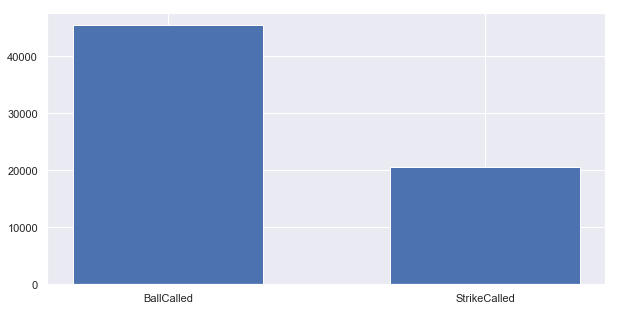

In [64]:
# distribution of the label
types = ('BallCalled', 'StrikeCalled')
y_pos = np.arange(len(types))
n = data['PITCH_RESULT'].value_counts().to_list()

plt.figure(figsize=(10, 5))
plt.bar(y_pos, n, align='center', width=0.6, color='b')
plt.xticks(y_pos, types)
plt.show()

In [65]:
# model training (1)
possible_features = ['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID', 'BALLS', 'STRIKES', 'OUTS',
                     'INNING', 'BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_TYPE', 'PITCH_SPEED', 'SPIN_RATE',
                     'PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT', 'STRIKE_ZONE_TOP', 'STRIKE_ZONE_BOTTOM',
                     'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'VERTICAL_APPROACH_ANGLE',
                     'HORIZONTAL_APPROACH_ANGLE', 'RELEASE_HEIGHT', 'RELEASE_SIDE', 'RELEASE_EXTENSION']
X = data[possible_features].to_numpy()
y = data[['PITCH_RESULT']].to_numpy().ravel()
params = {'boosting_type':'gbdt', 'objective':'binary'}
optimal_params = bayes_tuning(X, y, params)
lgbc_results = lgb_classification(X, y, params, optimal_params)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.9253   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.9265   |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.8738   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.9171   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.9267   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.9207   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.9204   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.9255   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.9286   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.9279   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.9267   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.9254   |  0.2662   | 

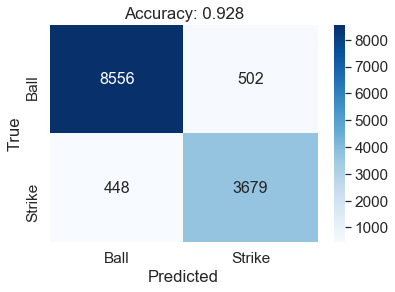

In [66]:
# accuracy and confusion matrix (1)
label = ['Ball', 'Strike']
df_cm = pd.DataFrame(lgbc_results[2], columns=np.unique(label), index=np.unique(label))
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'        
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g')
plt.title('Accuracy: {}'.format(round(lgbc_results[1],3)))
plt.show()

## 5. Feature Importance and Feature Selection
After training and evaluating the model, we then try to figure out which features have significant impact on classifying whether a given pitch is a strike or ball by calculating feature importance. As shown in the first figure, it's obvious that `PITCH_LOCATION_SIDE`, `PITCH_LOCATION_HEIGHT` and `UMPIRE_ID` have the significant impacts on classifying whether a given pitch is a strike or ball. This result is pretty reasonable since an umpire judges whether a pitch is a strike or ball on the basis of the pitch's location. Besides, it's also reasonable that every umpires' judgements are different.

Next, regarding feature selection, we choose to use [**Forward Sequential Feature Selection**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html). It is a greedy procedure that starts with zero feature and find a feature that maximizes the 5-fold cross-validation test accuracy. Once that first feature is selected, the procedure then iteratively finds the best new feature to add to the set of selected features. As shown in the second figure, it's obvious that the curve jumps to an overall test accuracy of around 92.5% when two features, `PITCH_LOCATION_SIDE` and `PITCH_LOCATION_HEIGHT`, are captured, and there doesn’t appear to be much improvement in the overall test accuracy after those two features.

From a statistical perspective, it's appropriate to only include `PITCH_LOCATION_SIDE` and `PITCH_LOCATION_HEIGHT` in a LightGBM model on the basis of the results of feature importance and feature selection. However, as a huge baseball enthusiast, we believe it's valuable to figure out each umpire's true strike zone shape under various conditions such as count, batter side, and so on. Therefore, for future visualization and analysis, we decide to consider `PITCH_LOCATION_SIDE`, `PITCH_LOCATION_HEIGHT`, `UMPIRE_ID`, `BALLS`, `STRIKES`, `OUTS`, `BATTER_SIDE` and, `PITCHER_SIDE` as final model features (i.e., predictors). 

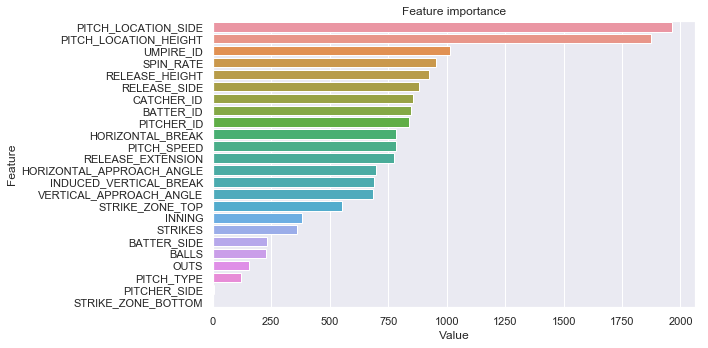

In [67]:
# feature importance 
feature_imp = pd.DataFrame({'Value': lgbc_results[0].feature_importances_,
                            'Feature': possible_features})
plt.figure(figsize=(10, 5))
sns.set(font_scale = 1)
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show()

In [44]:
# feature selection
selected_features = []
for i in np.linspace(1, len(possible_features)-1, len(possible_features)-1, dtype=int):
    sfs_forward = SequentialFeatureSelector(lgbc_results[0], n_features_to_select=i, direction='forward').fit(X, y)
    selected_features.append([x for x, y in zip(possible_features, sfs_forward.get_support()) if y == True])

In [ ]:
accuracy = []
for features in selected_features:
    X = data[features].to_numpy()
    y = data[['PITCH_RESULT']].to_numpy().ravel()
    params = {'boosting_type':'gbdt', 'objective':'binary'}
    optimal_params = bayes_tuning(X, y, params)
    lgbc_results = lgb_classification(X, y, params, optimal_params)
    accuracy.append(lgbc_results[1])

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('Number of features selected')
plt.ylabel('Test Accuracy')
plt.plot(np.linspace(1, len(possible_features)-1, len(possible_features)-1, dtype=int), accuracy)
plt.show()

## 6. Probability Calibration
As discussed in the previous section, for future visualization and analysis, we decide to consider `PITCH_LOCATION_SIDE`, `PITCH_LOCATION_HEIGHT`, `UMPIRE_ID`, `BALLS`, `STRIKES`, `OUTS`, `BATTER_SIDE`, and `PITCHER_SIDE` as the final model features. Therefore, we are able to use the two defined functions in the section 3 again to train a new LightGBM model. Similarly, we evaluate our final LightGBM model using overall test accuracy and confusion matrix. The test accuracy is approximately equal to 93% and the confusion matrix confirms there is no significant class imbalanced issue, which indicates our final LightGBM model is also pretty decent.  

However, in classification tasks, test accuracy only measures how often we are correct and says nothing about how confident we are in being correct. Therefore, classification models tend to have much weaker and more systematically biased probability prediction forecasts. Hence, since our goal is to classify whether a given pitch is a strike or ball and further predict its called strike probability, it's necessary to evaluate probability forecasting performance of our final LightGBM model. Meanwhile, we try to adjust our predicted called strike probabilities by calibrating our final LightGBM model using sigmoid and isotonic methods. 

As shown in the below figure, in the blue, we could see that the uncalibrated probabilities of our final LightGBM model are already pretty close to the true mean probabilities (i.e., gray dotted line). Besides, in the yellow and the red, the sigmoid adjusted probabilities and the isotonic adjusted probabilities don't show too much improvement. Therefore, in the next two chapter, we will directly use our final LightGBM model without any calibration to predict a given pitch's called strike probability. Finally, we can visualize each umpire's true strike zone shape under various conditions and calculate which pitcher lost the most strikes.

In [68]:
# model training (2)
final_features = ['UMPIRE_ID', 'BALLS', 'STRIKES', 'OUTS', 'BATTER_SIDE', 'PITCHER_SIDE',
                  'PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT']
X = data[final_features].to_numpy()
y = data[['PITCH_RESULT']].to_numpy().ravel()
params = {'boosting_type':'gbdt', 'objective':'binary'}
optimal_params = bayes_tuning(X, y, params)
lgbc_results = lgb_classification(X, y, params, optimal_params)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.9197   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.927    |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.9132   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.9173   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.9239   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.9232   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.9177   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.9238   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.9254   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.9251   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.9254   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.9224   |  0.2662   | 

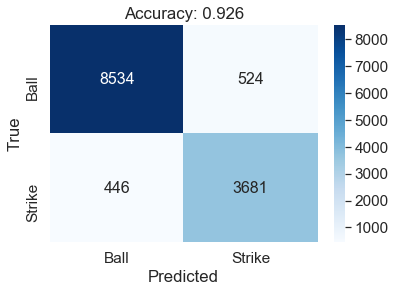

In [69]:
# accuracy and confusion matrix (2)
label = ['Ball', 'Strike']
df_cm = pd.DataFrame(lgbc_results[2], columns=np.unique(label), index=np.unique(label))
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'        
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g')
plt.title('Accuracy: {}'.format(round(lgbc_results[1],3)))
plt.show()

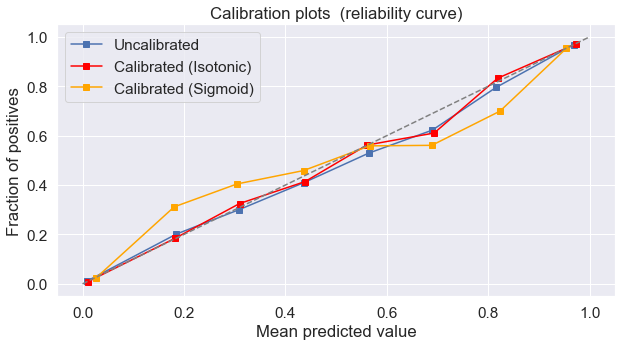

In [74]:
# probability calibration
fig, ax = plt.subplots(figsize=(10, 5))

X = data[final_features].to_numpy()
y = data[['PITCH_RESULT']].to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# uncalibrated
y_test_predict_proba = lgbc_results[0].predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Uncalibrated')

# calibrated by isotonic method
clf_isotonic = CalibratedClassifierCV(lgbc_results[0], cv=5, method='isotonic')
clf_isotonic.fit(X_train, y_train.ravel())
y_test_predict_proba = clf_isotonic.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Calibrated (Isotonic)')

# calibrated by sigmoid method
clf_sigmoid = CalibratedClassifierCV(lgbc_results[0], cv=5, method='sigmoid')
clf_sigmoid.fit(X_train, y_train.ravel())
y_test_predict_proba = clf_sigmoid.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='orange', label='Calibrated (Sigmoid)')

ax.set_title('Calibration plots  (reliability curve)')
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.legend()
plt.show()

## 7. Visualization
In this section, we are going to visualize each umpire's strike zone shape under various conditions such as count, batter side, and so on. First, we use the two defined functions in the section 3 to train a LightGBM model with only two features, `PITCH_LOCATION_SIDE` and `PITCH_LOCATION_HEIGHT`, which denoted as **Mode 1** in the below figures. Meanwhile, as discussed in the previous section, we then use the two defined functions again to train another LightGBM model with the final model features, `PITCH_LOCATION_SIDE`, `PITCH_LOCATION_HEIGHT`, `UMPIRE_ID`, `BALLS`, `STRIKES`, `OUTS`, `BATTER_SIDE`, and `PITCHER_SIDE`, which denoted as **Mode 2** in the below figures. 

After that, we use **Mode 1** and **Mode 2** to estimate the called strike probability of each pitch's location, respectively, and further generate two 2D heatmaps to depict the called strike probability across the pitched ball’s
horizontal and vertical locations. The only difference is that **Mode 2** is given `UMPIRE_ID`, `BALLS`, `STRIKES`, `OUTS`, `BATTER_SIDE`, and `PITCHER_SIDE`. As shown in the first figure, **Mode 1** actually generates a general strike zone shape while **Mode 2** generates a specific strike zone shape of a umpire whose ID is 10 with a left batter and a right pitcher in a 3-2 count and 2 outs. Next, as shown in the second figure, through comapring the 50% contours for called strike probability, it's obvious that the specific strike zone shape is smaller than the general strike zone shape, which provides valuable information for coaches and players.

However, since there are too many combinations of `UMPIRE_ID`, `BALLS`, `STRIKES`, `OUTS`, `BATTER_SIDE`, and `PITCHER_SIDE`, we decide to utilize **Flask** and **AWS EC2** to build a website with multiple filters, including umpire ID, strikes, balls, outs, batter side, and pitcher side, to visualize each umpire's strike zone shape under various circumstances. Please visit the website from the link below: http://100.26.249.73/. It's important to note that it takes around 30 seconds to run once.

In [75]:
# input data
x_grid = np.linspace(-2.5, 2.5, 500)
y_grid = np.linspace(0, 5, 500)
xx, yy = np.meshgrid(x_grid, y_grid)
coords = np.array((xx.ravel(), yy.ravel())).T
others = np.repeat(np.array([[10, 3, 2, 2, 0, 1]]), 500*500, axis=0)
input_x = np.concatenate((others, coords), axis=1)

# output data
features0 = ['PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT']
features1 = ['UMPIRE_ID', 'BALLS', 'STRIKES', 'OUTS', 'BATTER_SIDE',
             'PITCHER_SIDE', 'PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT']

results = []
for feature, input_data in zip([features0, features1], [coords, input_x]):
    X = data[feature].to_numpy()
    y = data[['PITCH_RESULT']].to_numpy().ravel()
    params = {'boosting_type': 'gbdt', 'objective': 'binary'}
    optimal_params = bayes_tuning(X, y, params)
    lgbc_results = lgb_classification(X, y, params, optimal_params)
    result = lgbc_results[0].predict_proba(input_data)
    results.append(result[:, 1].reshape(500, 500))

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.9112   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.9204   |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.9024   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.9086   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.9157   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.9195   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.9078   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.9229   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.9204   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.9218   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.9157   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.9141   |  0.2662   | 

|  25       |  0.916    |  0.7452   |  16.23    |  38.02    |  33.35    |
|  26       |  0.9063   |  0.8882   |  16.4     |  35.41    |  120.3    |
|  27       |  0.9238   |  0.06056  |  2.955    |  60.93    |  104.7    |
|  28       |  0.9261   |  0.2493   |  4.947    |  23.37    |  175.8    |
|  29       |  0.9193   |  0.4672   |  27.74    |  77.35    |  165.3    |
|  30       |  0.9209   |  0.02443  |  3.979    |  21.45    |  177.2    |
|  31       |  0.9252   |  0.04779  |  6.489    |  20.86    |  86.47    |
|  32       |  0.9204   |  0.6654   |  6.061    |  25.03    |  176.6    |
|  33       |  0.9155   |  0.8269   |  28.87    |  79.82    |  167.1    |
|  34       |  0.9123   |  0.926    |  6.798    |  22.82    |  178.0    |
|  35       |  0.9234   |  0.286    |  7.84     |  22.08    |  84.74    |
|  36       |  0.9221   |  0.3437   |  7.538    |  22.13    |  87.31    |
|  37       |  0.9257   |  0.08951  |  6.095    |  23.33    |  175.0    |
|  38       |  0.9235   |  0.1796   | 

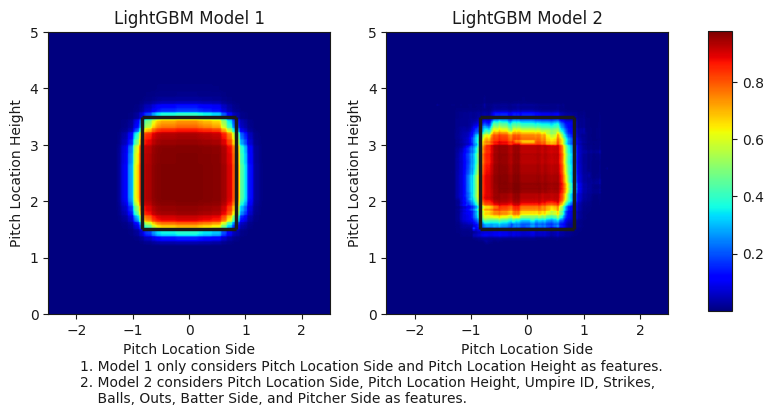

In [99]:
# visualization (1)
lines = [[(0.835, 1.5), (0.835, 3.5)], [(0.835, 3.5), (-0.835, 3.5)],
         [(-0.835, 3.5), (-0.835, 1.5)], [(-0.835, 1.5), (0.835, 1.5)]]
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for z, ax, title in zip(results, axes, ['LightGBM Model 1', 'LightGBM Model 2']):
    lc = mc.LineCollection(lines, linewidths=2.5, colors='k')
    smoothing_z = gaussian_filter(z, sigma=1.3)
    im = ax.imshow(smoothing_z, extent=[-2.5, 2.5, 0, 5], origin='lower', cmap='jet')
    ax.add_collection(lc)
    ax.axis('scaled')
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([0, 5])
    ax.set_title(title)
    ax.set_xlabel('Pitch Location Side')
    ax.set_ylabel('Pitch Location Height')
cax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cax)
fig.text(0.165, 0, "1. Model 1 only considers Pitch Location Side and Pitch Location Height as features.", ha='left')
fig.text(0.165, -0.08, "2. Model 2 considers Pitch Location Side, Pitch Location Height, Umpire ID, Strikes,\n    Balls, Outs, Batter Side, and Pitcher Side as features.", ha='left')
plt.show()

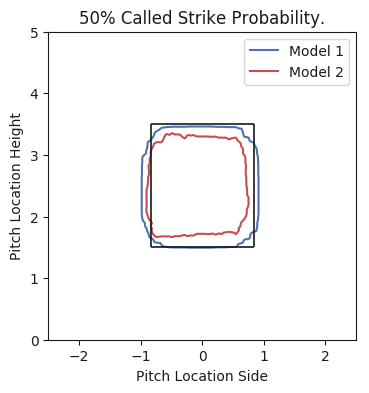

In [100]:
# visualization (2)
fig, ax = plt.subplots(figsize=(4, 4))
lc = mc.LineCollection(lines, linewidths=1.2, colors='k')
plt.contour(xx, yy, gaussian_filter(results[0], sigma=1.6), levels = [0.5], colors='b')
plt.contour(xx, yy, gaussian_filter(results[1], sigma=1.6), levels = [0.5], colors='r')
ax.add_collection(lc)
ax.axis('scaled')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([0, 5])
ax.set_title('50% Called Strike Probability.')
ax.set_xlabel('Pitch Location Side')
ax.set_ylabel('Pitch Location Height')    
line = [Line2D([0], [0], color=c, linewidth=1.5) for c in ['b', 'r']]
label = ['Model 1', 'Model 2']
plt.legend(line, label)
plt.show()

## 8. Further Analysis of Pitchers
In this section, we are going to calculate which pitcher lost the most strikes. Similarly, we use the two defined functions in the section 3 to train a LightGBM model with the final model features, `PITCH_LOCATION_SIDE`, `PITCH_LOCATION_HEIGHT`, `UMPIRE_ID`, `BALLS`, `STRIKES`, `OUTS`, `BATTER_SIDE`, and `PITCHER_SIDE`. Then, according to the section 2, we only select a subset of the given data whose pitch results are **Strike Called** or **Ball Called**. Therefore, we use the LightGBM model to classify whether each pitch in the subset is a strike or ball. A pitch is defined as a lost strike if its actual pitch result is **Ball Called** and its predicted pitch result is **Strike Called**. Finally, we create a leaderboard of lost strikes for pitchers. As shown in the below table, a pitch whose ID is 431 lost the most strikes, which is equal to 23.

In [133]:
# pitcher who lost the most strikes 
final_features = ['UMPIRE_ID', 'BALLS', 'STRIKES', 'OUTS', 'BATTER_SIDE', 'PITCHER_SIDE',
                  'PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT']
X = data[final_features].to_numpy()
y = data[['PITCH_RESULT']].to_numpy().ravel()
y_pred = lgbc_results[0].predict(X)

arr = np.subtract(y_pred, np.array(data['PITCH_RESULT']))
arr[arr < 0] = 0
data['LOST_STRIKES'] = arr
leaderboard = data.groupby('PITCHER_ID').agg({'LOST_STRIKES': 'sum'}).sort_values('LOST_STRIKES',
                                                                                  ascending=False).reset_index()

leaderboard[leaderboard['LOST_STRIKES'] > 0][0:50]

,PITCHER_ID,LOST_STRIKES
0,431,23
1,288,17
2,206,17
3,398,15
4,192,15
5,12,14
6,389,14
7,179,14
8,75,14
9,497,14


## 9. Conclusion
In this task, in order to classify whether a given pitch is a strike or ball and further predict its called strike probability, we develop a framework including feature preprocessing, model building, hyperparameter tuning, model evaluation, feature importance, feature selection, probability calibration, visualization, and further analysis of pitchers. However, it's worth to have a further discussion about which features should include in a classification model. Although the results might not be perfect, we believe that we still provide a reliable framework to deal with this kind of issue.